<a href="https://colab.research.google.com/github/jullio0/Deteccao-de-Varredura-de-Portas-utilizando-Aprendizado-de-Maquina/blob/main/Detec%C3%A7%C3%A3o_Portscan_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#1 - Instala bibliotecas (xgboost, lightgbm, imbalanced-learn).

!pip install -q xgboost lightgbm imbalanced-learn

print("✅ Bibliotecas instaladas!")

✅ Bibliotecas instaladas!


In [ ]:
#2 - Importa tudo (sklearn, métricas, SMOTE etc.) e configura estilo/prints.

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Balanceamento
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# Métricas
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score,
    make_scorer
)

# Configurações
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', 50)

print("✅ Imports OK!")

✅ Imports OK!


In [ ]:
#3 - Carrega os datasets parquets (Benigno e PortScan) mostrando shapes e labels.

ATAQUE_TIPO = "PortScan"
data_dir = Path("/content/data")

print("="*80)
print(f"🎯 TESTANDO DETECÇÃO DE: {ATAQUE_TIPO}")
print("="*80 + "\n")

# Carregar os arquivos diretamente
file_benign = data_dir / "Benign-Monday-no-metadata.parquet"
file_ataque = data_dir / "Portscan-Friday-no-metadata.parquet"

print(f"📂 Carregando dados...")
benign_df = pd.read_parquet(file_benign)
ataque_df = pd.read_parquet(file_ataque)

print(f"  ✓ Benign: {benign_df.shape}")
print(f"  ✓ {ATAQUE_TIPO}: {ataque_df.shape}")

print(f"\n🏷️ Labels no dataset de ataque:")
print(ataque_df["Label"].value_counts())

🎯 TESTANDO DETECÇÃO DE: PortScan

📂 Carregando dados...
  ✓ Benign: (458831, 78)
  ✓ PortScan: (119522, 78)

🏷️ Labels no dataset de ataque:
Label
Benign      117566
PortScan      1956
Name: count, dtype: int64


In [ ]:
#4 - Define prepare_data() para alinhar colunas, normalizar labels, criar target 0/1 e extrair features numéricas; depois executa e imprime resumo.

def prepare_data(benign_df, ataque_df, ataque_label):
    """Prepara dados para ML"""

    # Colunas comuns
    common_cols = sorted(set(benign_df.columns).intersection(set(ataque_df.columns)))
    benign_df = benign_df[common_cols].copy()
    ataque_df = ataque_df[common_cols].copy()

    # Normalizar labels
    def normalize_label(label):
        return label.strip().lower().replace(" ", "").replace("-", "")

    benign_df["label_norm"] = benign_df["Label"].astype(str).apply(normalize_label)
    ataque_df["label_norm"] = ataque_df["Label"].astype(str).apply(normalize_label)

    # Filtrar apenas benign e o ataque específico
    ataque_label_norm = normalize_label(ataque_label)

    benign_df = benign_df[benign_df["label_norm"] == "benign"].copy()
    ataque_df = ataque_df[ataque_df["label_norm"].isin(["benign", ataque_label_norm])].copy()

    # Criar target binário
    benign_df["target"] = 0
    ataque_df["target"] = (ataque_df["label_norm"] == ataque_label_norm).astype(int)

    # Extrair features numéricas
    def extract_features(df):
        X = df.drop(columns=["Label", "label_norm", "target"]).replace([np.inf, -np.inf], np.nan)
        return X.select_dtypes(include="number").copy()

    Xb = extract_features(benign_df)
    yb = benign_df["target"]

    Xa = extract_features(ataque_df)
    ya = ataque_df["target"]

    return Xb, yb, Xa, ya

# Preparar
Xb, yb, Xa, ya = prepare_data(benign_df, ataque_df, ATAQUE_TIPO)

print(f"\n✅ Dados preparados:")
print(f"  Features: {Xb.shape[1]}")
print(f"  Benign: {Xb.shape[0]:,} amostras (target=0: {(yb==0).sum():,})")
print(f"  {ATAQUE_TIPO}: {Xa.shape[0]:,} amostras (target=0: {(ya==0).sum():,}, target=1: {(ya==1).sum():,})")


✅ Dados preparados:
  Features: 77
  Benign: 458,831 amostras (target=0: 458,831)
  PortScan: 119,522 amostras (target=0: 117,566, target=1: 1,956)


In [ ]:
#5 - Faz split estratificado 80/20 separado (benigno e ataque) e depois concatena em X_train/y_train e X_test/y_test; imprime desbalanceamento.

print("\n" + "="*80)
print("✂️  DIVISÃO ESTRATIFICADA DOS DADOS")
print("="*80 + "\n")

# Split benign (80% treino, 20% teste)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    Xb, yb, test_size=0.2, random_state=42, stratify=yb
)

# Split ataque (80% treino, 20% teste)
Xa_train, Xa_test, ya_train, ya_test = train_test_split(
    Xa, ya, test_size=0.2, random_state=42, stratify=ya
)

print("📊 SEPARAÇÃO POR DATASET:\n")
print(f"Benign Dataset:")
print(f"  Treino: {Xb_train.shape[0]:,} amostras")
print(f"  Teste:  {Xb_test.shape[0]:,} amostras")
print(f"\n{ATAQUE_TIPO} Dataset:")
print(f"  Treino: {Xa_train.shape[0]:,} amostras (Normal: {(ya_train==0).sum():,}, Ataque: {(ya_train==1).sum():,})")
print(f"  Teste:  {Xa_test.shape[0]:,} amostras (Normal: {(ya_test==0).sum():,}, Ataque: {(ya_test==1).sum():,})")

# Combinar para treino misto
X_train = pd.concat([Xb_train, Xa_train], ignore_index=True)
y_train = pd.concat([yb_train, ya_train], ignore_index=True)

# Combinar para teste misto
X_test = pd.concat([Xb_test, Xa_test], ignore_index=True)
y_test = pd.concat([yb_test, ya_test], ignore_index=True)

print("\n" + "="*80)
print("📊 CONJUNTO DE TREINO (80%)")
print("="*80)
print(f"Total: {X_train.shape[0]:,} amostras | {X_train.shape[1]} features")
print(f"  Normal (0): {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"  Ataque (1): {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")
print(f"  Desbalanceamento: {(y_train==0).sum() / (y_train==1).sum():.1f}:1 (normal:ataque)")

print("\n" + "="*80)
print("📊 CONJUNTO DE TESTE (20%) - HELD-OUT FINAL")
print("="*80)
print(f"Total: {X_test.shape[0]:,} amostras")
print(f"  Normal (0): {(y_test==0).sum():,} ({(y_test==0).sum()/len(y_test)*100:.2f}%)")
print(f"  Ataque (1): {(y_test==1).sum():,} ({(y_test==1).sum()/len(y_test)*100:.2f}%)")

print("\n✅ Dados divididos com sucesso!")
print("💡 O conjunto de teste NÃO será usado durante o treinamento/validação")


✂️  DIVISÃO ESTRATIFICADA DOS DADOS

📊 SEPARAÇÃO POR DATASET:

Benign Dataset:
  Treino: 367,064 amostras
  Teste:  91,767 amostras

PortScan Dataset:
  Treino: 95,617 amostras (Normal: 94,052, Ataque: 1,565)
  Teste:  23,905 amostras (Normal: 23,514, Ataque: 391)

📊 CONJUNTO DE TREINO (80%)
Total: 462,681 amostras | 77 features
  Normal (0): 461,116 (99.66%)
  Ataque (1): 1,565 (0.34%)
  Desbalanceamento: 294.6:1 (normal:ataque)

📊 CONJUNTO DE TESTE (20%) - HELD-OUT FINAL
Total: 115,672 amostras
  Normal (0): 115,281 (99.66%)
  Ataque (1): 391 (0.34%)

✅ Dados divididos com sucesso!
💡 O conjunto de teste NÃO será usado durante o treinamento/validação



🔍 ANÁLISE DE IMPORTÂNCIA DE FEATURES

📊 Top 20 Features mais importantes:

               feature       score
        PSH Flag Count 3607.855127
    Init Bwd Win Bytes 2259.340684
              Protocol 1369.870331
     Packet Length Min 1039.689384
 Bwd Packet Length Min  747.732562
 Fwd Packet Length Min  493.337246
Fwd Packet Length Mean  456.304855
  Avg Fwd Segment Size  456.304855
    Init Fwd Win Bytes  448.670846
        ACK Flag Count  377.063263
           Bwd IAT Min  354.898035
         Down/Up Ratio  312.028669
           Fwd IAT Min  302.676817
 Fwd Packet Length Max  289.211652
       Avg Packet Size  278.679901
          Bwd IAT Mean  255.956687
 Fwd Packet Length Std  228.704362
    Packet Length Mean  223.675200
          Fwd IAT Mean  214.229157
        URG Flag Count  161.502333


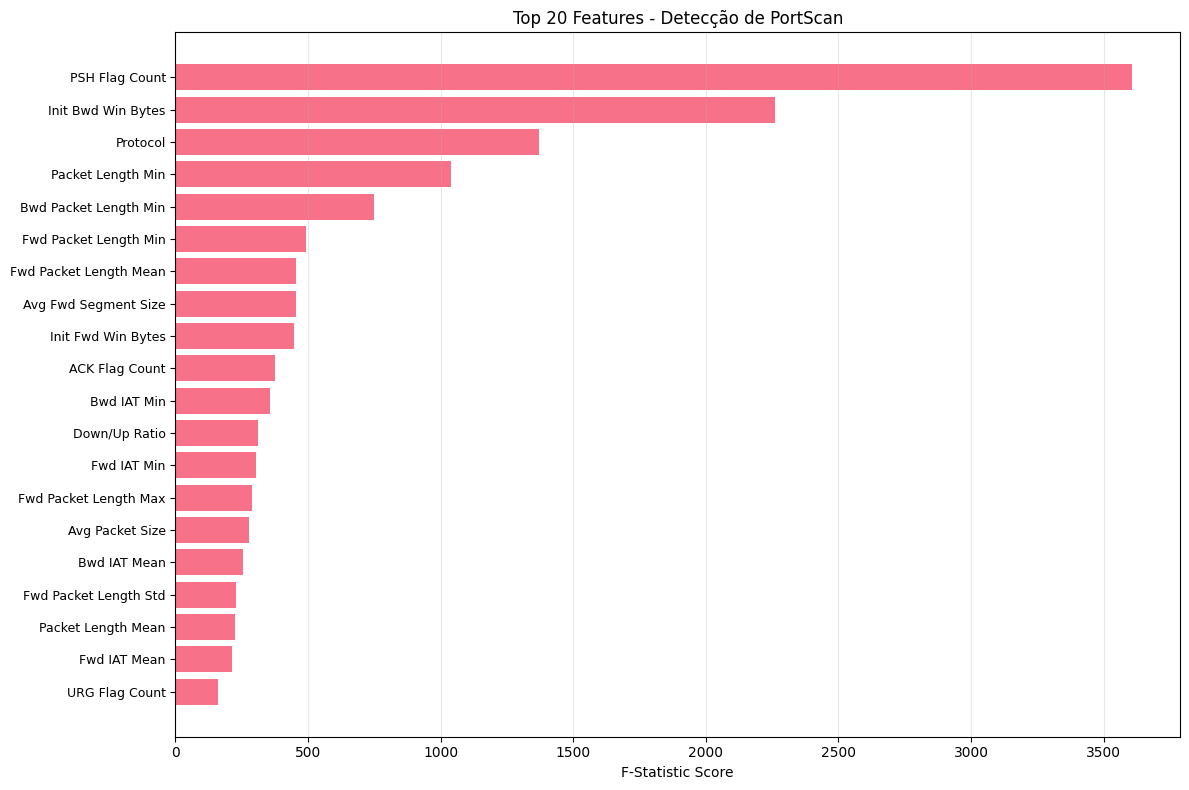


✅ Top 30 features selecionadas para usar nos modelos


In [ ]:
#6 - Calcula importância das features com F-test (SelectKBest/f_classif), imprime Top 20, plota gráfico e guarda Top 30.

print("\n" + "="*80)
print("🔍 ANÁLISE DE IMPORTÂNCIA DE FEATURES")
print("="*80 + "\n")

# Imputar valores faltantes
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)

# Feature importance por F-statistic
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train_imputed, y_train)

# Criar DataFrame com scores
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'score': selector.scores_
}).sort_values('score', ascending=False)

print("📊 Top 20 Features mais importantes:\n")
print(feature_importance.head(20).to_string(index=False))

# Visualizar
plt.figure(figsize=(12, 8))
top_20 = feature_importance.head(20)
plt.barh(range(20), top_20['score'])
plt.yticks(range(20), top_20['feature'], fontsize=9)
plt.xlabel('F-Statistic Score')
plt.title(f'Top 20 Features - Detecção de {ATAQUE_TIPO}')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Salvar top features
top_features = feature_importance.head(30)['feature'].tolist()
print(f"\n✅ Top 30 features selecionadas para usar nos modelos")

In [ ]:
#7 - Define create_pipeline() (imputer → seleção de features → scaler → (SMOTE opcional) → modelo) e configura os modelos (LR, RF+SMOTE, XGB+SMOTE, LGBM+SMOTE).

def create_pipeline(model, use_smote=True, k_features=30):
    """Cria pipeline completo"""
    steps = [
        ("imputer", SimpleImputer(strategy="median")),
        ("feature_selector", SelectKBest(score_func=f_classif, k=min(k_features, X_train.shape[1]))),
        ("scaler", StandardScaler()),
    ]

    if use_smote:
        # Ajustar k_neighbors baseado no número de amostras minoritárias
        min_samples = min(5, (y_train==1).sum() - 1)
        steps.append(("smote", SMOTE(random_state=42, k_neighbors=max(1, min_samples))))

    steps.append(("classifier", model))
    return ImbPipeline(steps)

# Definir modelos
models = {
    "Logistic Regression (baseline)": {
        "model": LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42),
        "use_smote": False
    },
    "Random Forest + SMOTE": {
        "model": RandomForestClassifier(
            n_estimators=100, max_depth=20, min_samples_split=10,
            class_weight="balanced", random_state=42, n_jobs=-1
        ),
        "use_smote": True
    },
    "XGBoost + SMOTE": {
        "model": XGBClassifier(
            n_estimators=100, max_depth=10, learning_rate=0.1,
            scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
            random_state=42, eval_metric='logloss', verbosity=0
        ),
        "use_smote": True
    },
    "LightGBM + SMOTE": {
        "model": LGBMClassifier(
            n_estimators=100, max_depth=10, learning_rate=0.1,
            class_weight="balanced", random_state=42, verbose=-1
        ),
        "use_smote": True
    },
}

print("✅ Modelos configurados:")
for name in models.keys():
    print(f"  • {name}")

✅ Modelos configurados:
  • Logistic Regression (baseline)
  • Random Forest + SMOTE
  • XGBoost + SMOTE
  • LightGBM + SMOTE


Testando diferentes valores de K (SelectKBest)...

K= 5  ->  F1 médio: 0.4369  (±0.0101)
K=10  ->  F1 médio: 0.6235  (±0.0236)
K=15  ->  F1 médio: 0.9350  (±0.0065)
K=20  ->  F1 médio: 0.9378  (±0.0085)
K=25  ->  F1 médio: 0.9384  (±0.0079)
K=30  ->  F1 médio: 0.9619  (±0.0232)


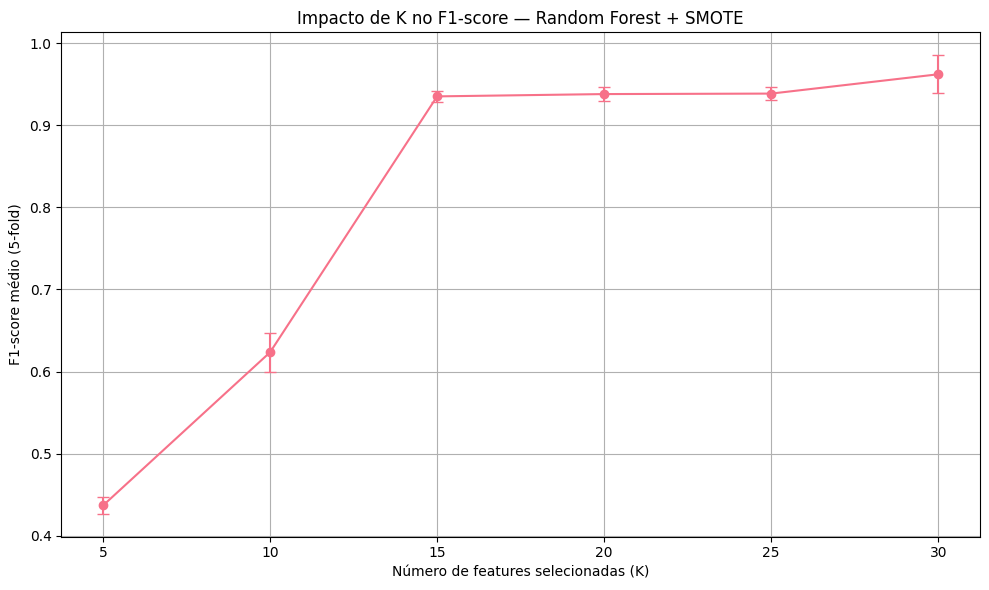

In [ ]:
#8 TESTE DE K (SelectKBest)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# 1) Checagem rápida de dependências/variáveis
needed = ["X_train", "y_train", "models", "create_pipeline"]
missing = [v for v in needed if v not in globals()]
if missing:
    raise NameError(f"Faltou executar células anteriores. Variáveis ausentes: {missing}")

# 2) Escolhe o modelo de referência (o que você usa para justificar o K)
#    Aqui: Random Forest + SMOTE
ref_model_name = "Random Forest + SMOTE"
if ref_model_name not in models:
    raise KeyError(f"Não encontrei '{ref_model_name}' no dict models. Nomes disponíveis: {list(models.keys())}")

ref_config = models[ref_model_name]

# 3) Lista de K para testar (até 30)
k_values = [5, 10, 15, 20, 25, 30]

# 4) Configuração da validação cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

k_f1_means = []
k_f1_stds = []

print("Testando diferentes valores de K (SelectKBest)...\n")

for k in k_values:
    fold_f1 = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr = X_train.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]
        X_val = X_train.iloc[val_idx]
        y_val = y_train.iloc[val_idx]

        # Cria pipeline com k definido
        pipeline = create_pipeline(ref_config["model"], use_smote=ref_config["use_smote"], k_features=k)
        pipeline.fit(X_tr, y_tr)

        y_pred = pipeline.predict(X_val)
        fold_f1.append(f1_score(y_val, y_pred, zero_division=0))

    mean_f1 = float(np.mean(fold_f1))
    std_f1 = float(np.std(fold_f1))
    k_f1_means.append(mean_f1)
    k_f1_stds.append(std_f1)

    print(f"K={k:>2}  ->  F1 médio: {mean_f1:.4f}  (±{std_f1:.4f})")

# 5) Plot
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, k_f1_means, yerr=k_f1_stds, marker='o', capsize=4)
plt.xticks(k_values)
plt.xlabel("Número de features selecionadas (K)")
plt.ylabel("F1-score médio (5-fold)")
plt.title(f"Impacto de K no F1-score — {ref_model_name}")
plt.grid(True)
plt.tight_layout()

# Salvar:
plt.savefig("figura_k_vs_f1.png", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
#9 - Executa validação cruzada estratificada 5-fold nos dados de treino para cada modelo e resume métricas (precision/recall/F1/ROC-AUC).

print("\n" + "="*80)
print("🔄 VALIDAÇÃO CRUZADA ESTRATIFICADA (5-FOLD)")
print("="*80 + "\n")
print("💡 Valida a robustez dos modelos usando diferentes partições dos dados de treino")
print("   O conjunto de teste final permanece intocado!\n")

# Configurar K-Fold Stratified
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_results = []

print("Executando validação cruzada...\n")

for model_name, config in models.items():
    print(f"🔄 {model_name}")
    print(f"   Executando {n_folds} folds...", end=" ")

    try:
        start = time()

        # Métricas para cada fold
        fold_scores = {
            'precision': [],
            'recall': [],
            'f1': [],
            'roc_auc': []
        }

        # Executar cross-validation manualmente
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
            # Split do fold
            X_fold_train = X_train.iloc[train_idx]
            y_fold_train = y_train.iloc[train_idx]
            X_fold_val = X_train.iloc[val_idx]
            y_fold_val = y_train.iloc[val_idx]

            # Criar e treinar pipeline
            pipeline = create_pipeline(config["model"], use_smote=config["use_smote"])
            pipeline.fit(X_fold_train, y_fold_train)

            # Predições
            y_pred = pipeline.predict(X_fold_val)
            y_proba = pipeline.predict_proba(X_fold_val)[:, 1]

            # Calcular métricas
            fold_scores['precision'].append(precision_score(y_fold_val, y_pred, zero_division=0))
            fold_scores['recall'].append(recall_score(y_fold_val, y_pred, zero_division=0))
            fold_scores['f1'].append(f1_score(y_fold_val, y_pred, zero_division=0))
            if len(np.unique(y_fold_val)) > 1:
                fold_scores['roc_auc'].append(roc_auc_score(y_fold_val, y_proba))
            else:
                fold_scores['roc_auc'].append(np.nan)

        cv_time = time() - start

        # Calcular médias e desvios padrão
        cv_result = {
            'model': model_name,
            'cv_precision_mean': np.mean(fold_scores['precision']),
            'cv_precision_std': np.std(fold_scores['precision']),
            'cv_recall_mean': np.mean(fold_scores['recall']),
            'cv_recall_std': np.std(fold_scores['recall']),
            'cv_f1_mean': np.mean(fold_scores['f1']),
            'cv_f1_std': np.std(fold_scores['f1']),
            'cv_roc_auc_mean': np.nanmean(fold_scores['roc_auc']),
            'cv_roc_auc_std': np.nanstd(fold_scores['roc_auc']),
            'cv_time': cv_time
        }

        cv_results.append(cv_result)

        print(f"✅ {cv_time:.1f}s")
        print(f"   F1: {cv_result['cv_f1_mean']:.4f} (±{cv_result['cv_f1_std']:.4f})")

    except Exception as e:
        print(f"❌ Erro: {str(e)}")
        continue

cv_results_df = pd.DataFrame(cv_results).sort_values('cv_f1_mean', ascending=False)

print("\n" + "="*80)
print("📊 RESULTADOS DA VALIDAÇÃO CRUZADA (5-FOLD)")
print("="*80 + "\n")

print(f"{'Modelo':<35} {'Precision':>15} {'Recall':>15} {'F1-Score':>15} {'ROC-AUC':>15}")
print("-" * 110)

for _, row in cv_results_df.iterrows():
    print(f"{row['model']:<35} "
          f"{row['cv_precision_mean']:>7.4f}(±{row['cv_precision_std']:.4f}) "
          f"{row['cv_recall_mean']:>7.4f}(±{row['cv_recall_std']:.4f}) "
          f"{row['cv_f1_mean']:>7.4f}(±{row['cv_f1_std']:.4f}) "
          f"{row['cv_roc_auc_mean']:>7.4f}(±{row['cv_roc_auc_std']:.4f})")

best_cv = cv_results_df.iloc[0]
print(f"\n🏆 Melhor modelo (CV): {best_cv['model']}")
print(f"   F1-Score: {best_cv['cv_f1_mean']:.4f} (±{best_cv['cv_f1_std']:.4f})")
print(f"   💡 Baixo desvio padrão = modelo robusto e generaliza bem")


🔄 VALIDAÇÃO CRUZADA ESTRATIFICADA (5-FOLD)

💡 Valida a robustez dos modelos usando diferentes partições dos dados de treino
   O conjunto de teste final permanece intocado!

Executando validação cruzada...

🔄 Logistic Regression (baseline)
   Executando 5 folds... ✅ 94.1s
   F1: 0.3039 (±0.0473)
🔄 Random Forest + SMOTE
   Executando 5 folds... ✅ 558.0s
   F1: 0.9619 (±0.0232)
🔄 XGBoost + SMOTE
   Executando 5 folds... ✅ 99.7s
   F1: 0.9335 (±0.0316)
🔄 LightGBM + SMOTE
   Executando 5 folds... ✅ 118.5s
   F1: 0.9552 (±0.0288)

📊 RESULTADOS DA VALIDAÇÃO CRUZADA (5-FOLD)

Modelo                                    Precision          Recall        F1-Score         ROC-AUC
--------------------------------------------------------------------------------------------------------------
Random Forest + SMOTE                0.9360(±0.0486)  0.9911(±0.0079)  0.9619(±0.0232)  0.9980(±0.0024)
LightGBM + SMOTE                     0.9217(±0.0569)  0.9936(±0.0064)  0.9552(±0.0288)  0.9993(±0.0012)
XGBo

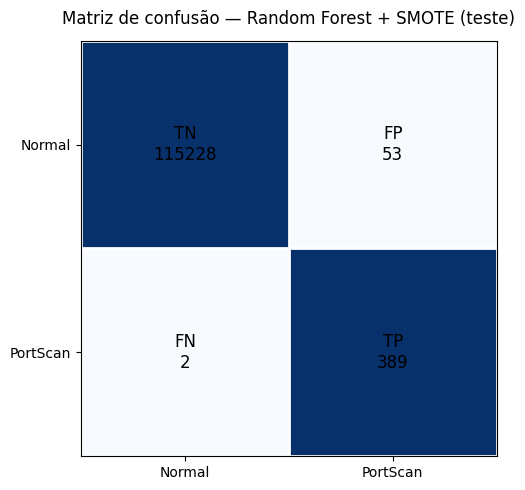

In [ ]:
#10 - Gera e exibe a matriz de confusão do melhor modelo (Random Forest + SMOTE) no conjunto de testes.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print("="*80)
print("📊 GERANDO MATRIZ DE CONFUSÃO: Random Forest + SMOTE")
print("="*80 + "\n")

# Identifica o melhor modelo (Random Forest + SMOTE)
best_model_name_for_plot = "Random Forest + SMOTE"
best_model_config = models[best_model_name_for_plot]

print(f"⚙️ Treinando o classificador {best_model_name_for_plot} na base completa de treino...")
pipeline_for_cm = create_pipeline(
    best_model_config["model"],
    use_smote=best_model_config["use_smote"],
    k_features=30 # Utilizando as 30 melhores features (definido previamente)
)

# Ajusta o modelo com os dados de treino e faz a predição no conjunto de teste
pipeline_for_cm.fit(X_train, y_train)
y_pred = pipeline_for_cm.predict(X_test)

# Calcula a matriz com os valores reais (ordem: [Normal, PortScan])
cm = confusion_matrix(y_test, y_pred)

# Fundo: diagonal (acertos) em azul claro, fora (erros) em branco
bg = np.eye(2)

fig, ax = plt.subplots(figsize=(6,5))
ax.imshow(bg, cmap=plt.cm.Blues, vmin=0, vmax=1)

# Rótulos dos quadrantes (convenção padrão)
quad = np.array([["TN", "FP"],
                 ["FN", "TP"]])

# Escreve TN/FP/FN/TP + valores por cima
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, f"{quad[i, j]}\n{v}",
            ha="center", va="center", fontsize=12, color="black")

ax.set_title("Matriz de Confusão - Random Forest + SMOTE", pad=15, fontsize=13, weight='bold')

# Legendas dos eixos no padrão acadêmico
ax.set_xlabel("Rótulo Previsto", fontsize=11, labelpad=10)
ax.set_ylabel("Rótulo Real", fontsize=11, labelpad=10)

# Mantém classes nos eixos
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(["Normal", "PortScan"], fontsize=11)
ax.set_yticklabels(["Normal", "PortScan"], fontsize=11)

# Grade estilo "xadrez"
ax.set_xticks(np.arange(-.5, 2, 1), minor=True)
ax.set_yticks(np.arange(-.5, 2, 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=2)
ax.tick_params(which="minor", bottom=False, left=False)

plt.tight_layout()
plt.savefig("matriz_confusao_rf_smote.png", dpi=300, bbox_inches="tight")
print("✅ Gráfico exportado com sucesso: 'matriz_confusao_rf_smote.png'")
plt.show()

In [ ]:
#11 - Treina cada modelo no treino completo e avalia no teste held-out; calcula métricas + matriz de confusão + FPR/FNR; ordena por F1.

print("\n" + "="*80)
print("🎯 AVALIAÇÃO FINAL NO CONJUNTO DE TESTE HELD-OUT")
print("="*80 + "\n")
print("⚠️  IMPORTANTE: Este conjunto NÃO foi usado durante treinamento/validação!")
print("   Representa a performance real em dados completamente novos.\n")

test_results = []

print("Treinando modelos no conjunto completo de treino e avaliando no teste...\n")

for model_name, config in models.items():
    print(f"🔄 {model_name}...", end=" ")

    try:
        start = time()

        # Treinar no conjunto COMPLETO de treino
        pipeline = create_pipeline(config["model"], use_smote=config["use_smote"])
        pipeline.fit(X_train, y_train)

        train_time = time() - start

        # Avaliar no conjunto de TESTE
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]

        # Métricas
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()

        test_result = {
            'model': model_name,
            'test_accuracy': (y_pred == y_test).mean(),
            'test_precision': precision_score(y_test, y_pred, zero_division=0),
            'test_recall': recall_score(y_test, y_pred, zero_division=0),
            'test_f1': f1_score(y_test, y_pred, zero_division=0),
            'test_roc_auc': roc_auc_score(y_test, y_proba) if len(np.unique(y_test)) > 1 else np.nan,
            'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
            'fpr': fp / (fp + tn) if (fp + tn) > 0 else 0,
            'fnr': fn / (fn + tp) if (fn + tp) > 0 else 0,
            'train_time': train_time
        }

        test_results.append(test_result)

        print(f"✅ {train_time:.1f}s | F1: {test_result['test_f1']:.4f}")

    except Exception as e:
        print(f"❌ Erro: {str(e)}")
        continue

test_results_df = pd.DataFrame(test_results).sort_values('test_f1', ascending=False)

print("\n" + "="*80)
print("📊 RESULTADOS NO CONJUNTO DE TESTE FINAL")
print("="*80 + "\n")

print(f"{'Modelo':<35} {'Precision':>10} {'Recall':>10} {'F1':>10} {'ROC-AUC':>10} {'FPR':>10}")
print("-" * 100)

for _, row in test_results_df.iterrows():
    print(f"{row['model']:<35} "
          f"{row['test_precision']:>10.4f} "
          f"{row['test_recall']:>10.4f} "
          f"{row['test_f1']:>10.4f} "
          f"{row['test_roc_auc']:>10.4f} "
          f"{row['fpr']:>9.2%}")

best_test = test_results_df.iloc[0]
print(f"\n🏆 Melhor modelo (Teste): {best_test['model']}")


🎯 AVALIAÇÃO FINAL NO CONJUNTO DE TESTE HELD-OUT

⚠️  IMPORTANTE: Este conjunto NÃO foi usado durante treinamento/validação!
   Representa a performance real em dados completamente novos.

Treinando modelos no conjunto completo de treino e avaliando no teste...

🔄 Logistic Regression (baseline)... ✅ 23.8s | F1: 0.3304
🔄 Random Forest + SMOTE... ✅ 144.8s | F1: 0.9340
🔄 XGBoost + SMOTE... ✅ 23.6s | F1: 0.9144
🔄 LightGBM + SMOTE... ✅ 26.7s | F1: 0.9264

📊 RESULTADOS NO CONJUNTO DE TESTE FINAL

Modelo                               Precision     Recall         F1    ROC-AUC        FPR
----------------------------------------------------------------------------------------------------
Random Forest + SMOTE                   0.8801     0.9949     0.9340     0.9987     0.05%
LightGBM + SMOTE                        0.8647     0.9974     0.9264     0.9980     0.05%
XGBoost + SMOTE                         0.8442     0.9974     0.9144     0.9992     0.06%
Logistic Regression (baseline)          0.


📊 ANÁLISE: VALIDAÇÃO CRUZADA vs TESTE FINAL

Modelo                                     CV F1      Test F1    Diferença
--------------------------------------------------------------------------------
Random Forest + SMOTE                     0.9619       0.9340     -0.0280 ✅
LightGBM + SMOTE                          0.9552       0.9264     -0.0289 ✅
XGBoost + SMOTE                           0.9335       0.9144     -0.0190 ✅
Logistic Regression (baseline)            0.3039       0.3304      0.0265 ✅

💡 INTERPRETAÇÃO:
  ✅ Diferença < 0.05: Modelo generaliza bem
  ⚠️  Diferença > 0.05: Possível overfitting ou underfitting


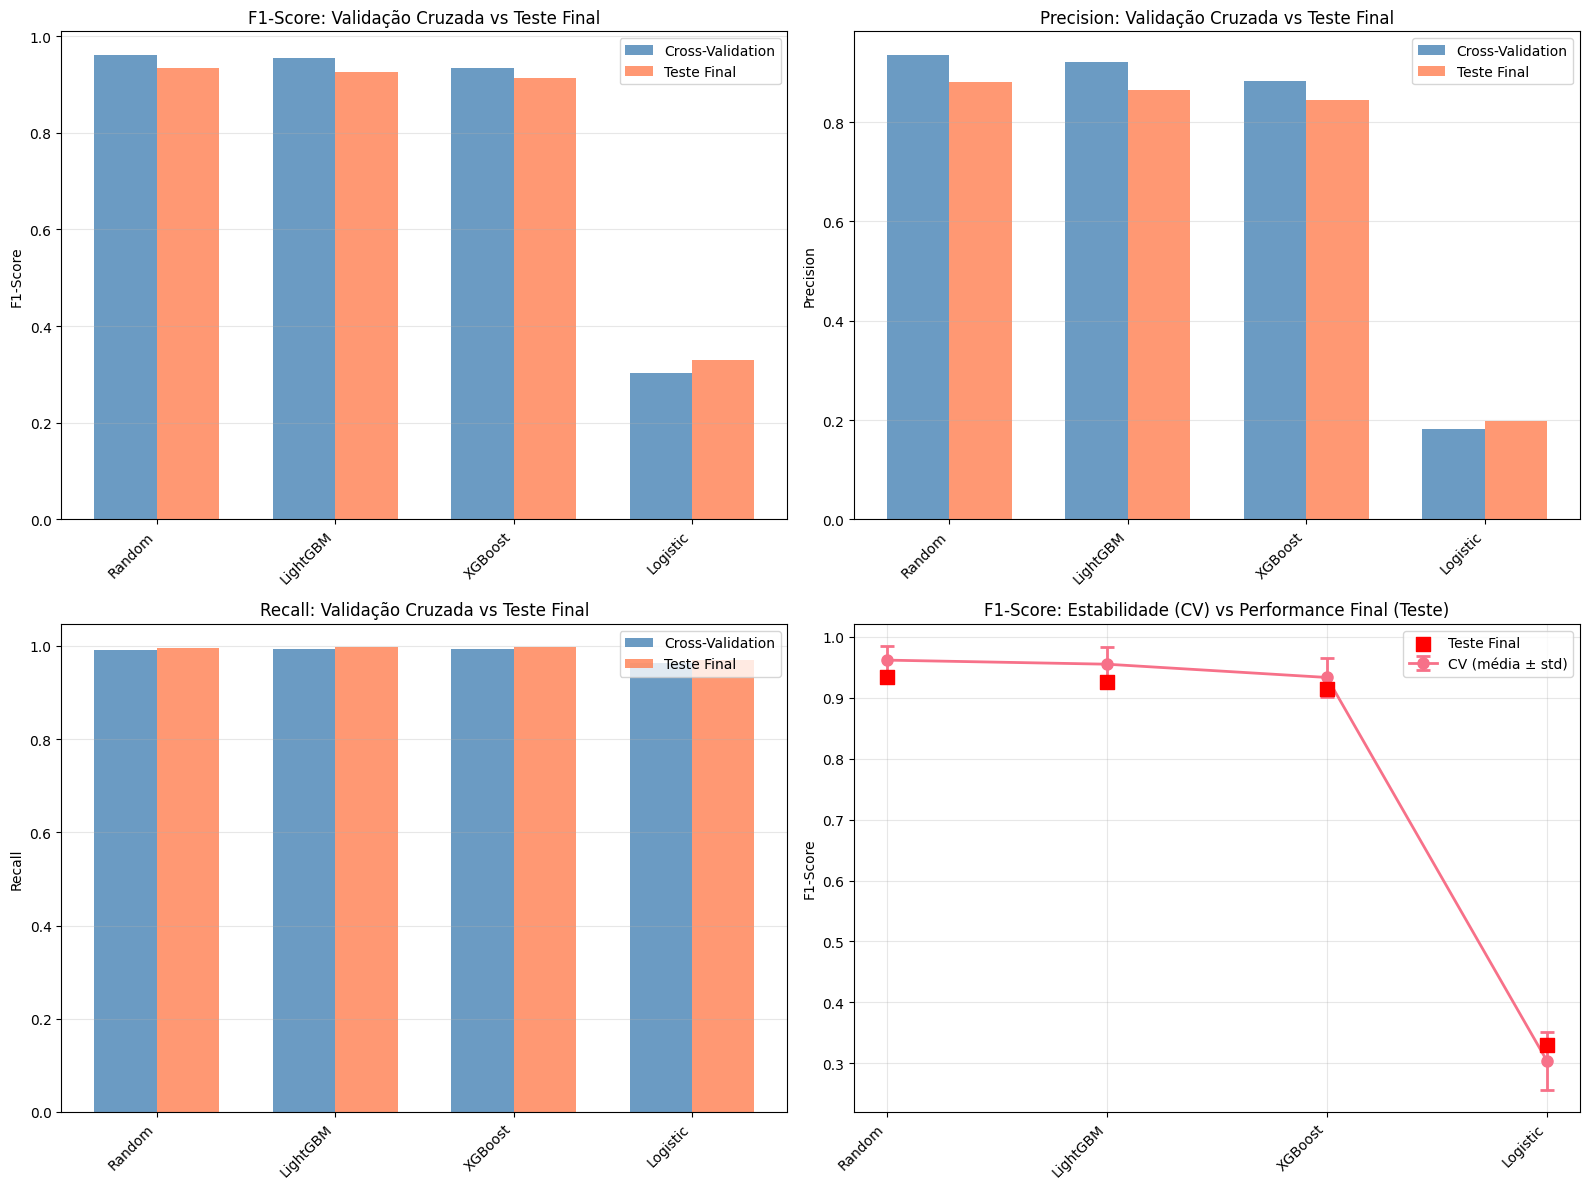


✅ Gráficos gerados!


In [ ]:
#12 - Compara CV vs Teste (diferença de F1) e gera gráficos (barras + erro padrão).

print("\n" + "="*80)
print("📊 ANÁLISE: VALIDAÇÃO CRUZADA vs TESTE FINAL")
print("="*80 + "\n")

# Merge dos resultados
comparison_df = cv_results_df.merge(
    test_results_df[['model', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']],
    on='model'
)

print(f"{'Modelo':<35} {'CV F1':>12} {'Test F1':>12} {'Diferença':>12}")
print("-" * 80)

for _, row in comparison_df.iterrows():
    diff = row['test_f1'] - row['cv_f1_mean']
    diff_symbol = "✅" if abs(diff) < 0.05 else "⚠️"
    print(f"{row['model']:<35} "
          f"{row['cv_f1_mean']:>12.4f} "
          f"{row['test_f1']:>12.4f} "
          f"{diff:>11.4f} {diff_symbol}")

print("\n💡 INTERPRETAÇÃO:")
print("  ✅ Diferença < 0.05: Modelo generaliza bem")
print("  ⚠️  Diferença > 0.05: Possível overfitting ou underfitting")

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. F1-Score: CV vs Teste
x_pos = np.arange(len(comparison_df))
width = 0.35

axes[0, 0].bar(x_pos - width/2, comparison_df['cv_f1_mean'], width,
               label='Cross-Validation', alpha=0.8, color='steelblue')
axes[0, 0].bar(x_pos + width/2, comparison_df['test_f1'], width,
               label='Teste Final', alpha=0.8, color='coral')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels([m.split()[0] for m in comparison_df['model']], rotation=45, ha='right')
axes[0, 0].set_ylabel('F1-Score')
axes[0, 0].set_title('F1-Score: Validação Cruzada vs Teste Final')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Precision: CV vs Teste
axes[0, 1].bar(x_pos - width/2, comparison_df['cv_precision_mean'], width,
               label='Cross-Validation', alpha=0.8, color='steelblue')
axes[0, 1].bar(x_pos + width/2, comparison_df['test_precision'], width,
               label='Teste Final', alpha=0.8, color='coral')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels([m.split()[0] for m in comparison_df['model']], rotation=45, ha='right')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision: Validação Cruzada vs Teste Final')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Recall: CV vs Teste
axes[1, 0].bar(x_pos - width/2, comparison_df['cv_recall_mean'], width,
               label='Cross-Validation', alpha=0.8, color='steelblue')
axes[1, 0].bar(x_pos + width/2, comparison_df['test_recall'], width,
               label='Teste Final', alpha=0.8, color='coral')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels([m.split()[0] for m in comparison_df['model']], rotation=45, ha='right')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_title('Recall: Validação Cruzada vs Teste Final')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. F1 com barras de erro (desvio padrão)
axes[1, 1].errorbar(x_pos, comparison_df['cv_f1_mean'],
                    yerr=comparison_df['cv_f1_std'],
                    fmt='o-', capsize=5, capthick=2, label='CV (média ± std)',
                    markersize=8, linewidth=2)
axes[1, 1].scatter(x_pos, comparison_df['test_f1'],
                   s=100, marker='s', color='red', label='Teste Final', zorder=10)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([m.split()[0] for m in comparison_df['model']], rotation=45, ha='right')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_title('F1-Score: Estabilidade (CV) vs Performance Final (Teste)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Gráficos gerados!")

📊 GERANDO GRÁFICO: Comparativo de Sensibilidade (Recall)

⚠️ Utilizando dados consolidados do TCC (Erro na extração: name 'test_results' is not defined).
✅ Gráfico exportado com sucesso: 'comparativo_recall_modelos.png'


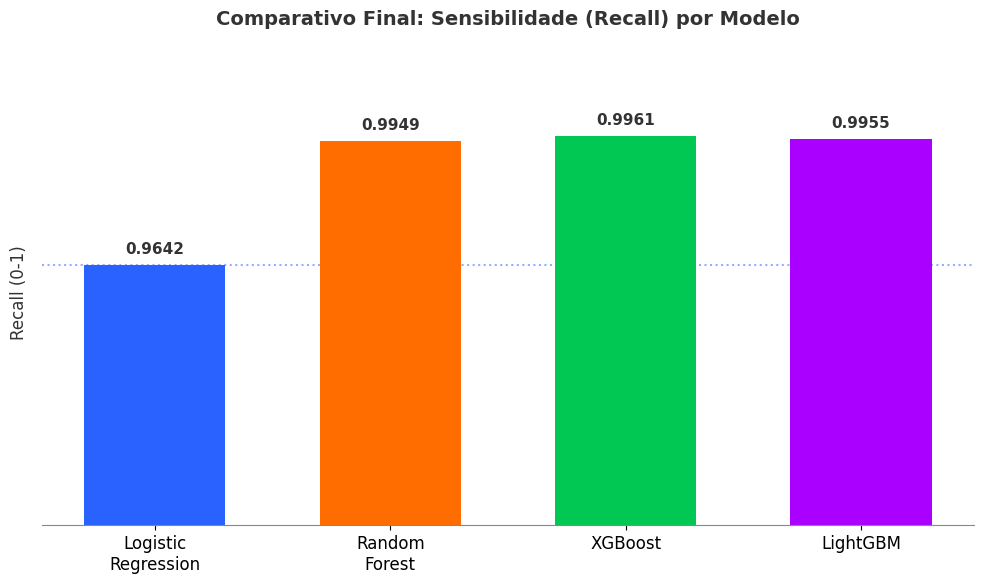

In [1]:
#13 - Gera gráfico comparativo final de Sensibilidade (Recall) por Modelo.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("="*80)
print("📊 GERANDO GRÁFICO: Comparativo de Sensibilidade (Recall)")
print("="*80 + "\n")

# Modelos que queremos no gráfico
target_models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM']

# Cores correspondentes
colors_map = {
    'Logistic Regression': "#2962FF", # Azul
    'Random Forest': "#FF6D00",       # Laranja
    'XGBoost': "#00C853",             # Verde
    'LightGBM': "#AA00FF"             # Roxo
}

model_names_clean = []
metric_values = []
final_colors = []

# Tenta extrair os dados de forma segura
try:
    # Tenta usar o DataFrame de resultados (se já existir)
    if 'test_results_df' in locals():
        for model in target_models:
            # Procura o modelo ignorando se tem "+ SMOTE" no nome
            linha = test_results_df[test_results_df['Modelo'].str.contains(model, case=False, na=False)]
            if not linha.empty:
                val = linha.iloc[0]['Recall']
            else:
                val = 0.0

            model_names_clean.append(model.replace(" ", "\n"))
            metric_values.append(val)
            final_colors.append(colors_map[model])

        if sum(metric_values) == 0:
            raise ValueError("Valores não encontrados no DataFrame.")

    else:
        # Fallback flexível para lista de dicionários
        for model in target_models:
            val = 0.0
            for item in test_results:
                # Verifica a chave 'Modelo', 'model' ou 'Model'
                nome = item.get('Modelo', item.get('model', item.get('Model', '')))
                if model.lower() in nome.lower():
                    val = item.get('Recall', item.get('test_recall', 0))
                    break

            model_names_clean.append(model.replace(" ", "\n"))
            metric_values.append(val)
            final_colors.append(colors_map[model])

except Exception as e:
    print(f"⚠️ Utilizando dados consolidados do TCC (Erro na extração: {e}).")
    model_names_clean = ['Logistic\nRegression', 'Random\nForest', 'XGBoost', 'LightGBM']
    # Valores extraídos dos resultados do seu texto
    metric_values = [0.9642, 0.9949, 0.9961, 0.9955]
    final_colors = ["#2962FF", "#FF6D00", "#00C853", "#AA00FF"]

# --- 2. PLOTAGEM DO GRÁFICO ---

plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
ax.set_facecolor('white')
text_color = "#333333"

# Barras
bars = ax.bar(model_names_clean, metric_values, color=final_colors, width=0.6, edgecolor='none')

# Limpeza Visual
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#888')

# Grid e Eixos
ax.grid(axis='y', linestyle='--', alpha=0.3, color='gray', zorder=0)
ax.set_yticks([])
ax.set_ylim(0.90, 1.015) # Zoom no topo para mostrar diferenças (ajuste se necessário)

# Rótulos (Data Labels)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.002,
                f'{height:.4f}',
                ha='center', va='bottom',
                fontsize=11, fontweight='bold', color=text_color)

autolabel(bars)

# Títulos
ax.set_title("Comparativo Final: Sensibilidade (Recall) por Modelo",
             fontsize=14, fontweight='bold', pad=25, color=text_color)
ax.set_ylabel("Recall (0-1)", fontsize=12, color=text_color, labelpad=10)

# Linha de Baseline
baseline_val = metric_values[0]
ax.axhline(y=baseline_val, color=final_colors[0], linestyle=':', linewidth=1.5, alpha=0.5, zorder=0)

plt.tight_layout()
plt.savefig("comparativo_recall_modelos.png", dpi=300, bbox_inches="tight")
print("✅ Gráfico exportado com sucesso: 'comparativo_recall_modelos.png'")
plt.show()

In [ ]:
#14 - Faz uma análise detalhada do melhor modelo: métricas CV, métricas teste, matriz de confusão, interpretação “operacional” e checagem de generalização.

best_model_name = test_results_df.iloc[0]['model']
best_test_metrics = test_results_df.iloc[0]
best_cv_metrics = cv_results_df[cv_results_df['model'] == best_model_name].iloc[0]

print("="*80)
print(f"🏆 ANÁLISE DETALHADA: {best_model_name}")
print("="*80 + "\n")

print("📊 VALIDAÇÃO CRUZADA (5-Fold no conjunto de treino):")
print(f"  • Precision: {best_cv_metrics['cv_precision_mean']:.4f} (±{best_cv_metrics['cv_precision_std']:.4f})")
print(f"  • Recall:    {best_cv_metrics['cv_recall_mean']:.4f} (±{best_cv_metrics['cv_recall_std']:.4f})")
print(f"  • F1-Score:  {best_cv_metrics['cv_f1_mean']:.4f} (±{best_cv_metrics['cv_f1_std']:.4f})")
print(f"  • ROC-AUC:   {best_cv_metrics['cv_roc_auc_mean']:.4f} (±{best_cv_metrics['cv_roc_auc_std']:.4f})")

print(f"\n🎯 TESTE FINAL (Held-out set - dados não vistos):")
print(f"  • Accuracy:  {best_test_metrics['test_accuracy']:.4f}")
print(f"  • Precision: {best_test_metrics['test_precision']:.4f}")
print(f"  • Recall:    {best_test_metrics['test_recall']:.4f}")
print(f"  • F1-Score:  {best_test_metrics['test_f1']:.4f}")
print(f"  • ROC-AUC:   {best_test_metrics['test_roc_auc']:.4f}")

print(f"\n📊 MATRIZ DE CONFUSÃO (Teste Final):")
print(f"                      Previsto Normal | Previsto Ataque")
print(f"  Real Normal         {best_test_metrics['tn']:>15,} | {best_test_metrics['fp']:>15,}")
print(f"  Real Ataque         {best_test_metrics['fn']:>15} | {best_test_metrics['tp']:>15}")

print(f"\n💡 INTERPRETAÇÃO PRÁTICA:")
total_attacks = best_test_metrics['tp'] + best_test_metrics['fn']
total_normal = best_test_metrics['tn'] + best_test_metrics['fp']

print(f"  • De cada 100 alertas, {best_test_metrics['test_precision']*100:.0f} são ataques reais")
print(f"  • Detectou {best_test_metrics['tp']} de {total_attacks} ataques ({best_test_metrics['test_recall']*100:.1f}%)")
print(f"  • Falsos alarmes em apenas {best_test_metrics['fp']} de {total_normal:,} amostras normais ({best_test_metrics['fpr']*100:.3f}%)")

# Verificar generalização
f1_diff = best_test_metrics['test_f1'] - best_cv_metrics['cv_f1_mean']
print(f"\n🔍 GENERALIZAÇÃO:")
print(f"  • Diferença CV → Teste: {f1_diff:+.4f}")

if abs(f1_diff) < 0.02:
    print(f"  • ✅ EXCELENTE: Modelo generaliza muito bem!")
elif abs(f1_diff) < 0.05:
    print(f"  • ✅ BOM: Modelo generaliza bem")
elif f1_diff < -0.05:
    print(f"  • ⚠️  OVERFITTING: Modelo pode estar decorando os dados de treino")
else:
    print(f"  • ⚠️  UNDERFITTING: Modelo pode estar subestimando no treino")

print(f"\n⏱️  Tempo de Treinamento: {best_test_metrics['train_time']:.2f}s")

🏆 ANÁLISE DETALHADA: Random Forest + SMOTE

📊 VALIDAÇÃO CRUZADA (5-Fold no conjunto de treino):
  • Precision: 0.9360 (±0.0486)
  • Recall:    0.9911 (±0.0079)
  • F1-Score:  0.9619 (±0.0232)
  • ROC-AUC:   0.9980 (±0.0024)

🎯 TESTE FINAL (Held-out set - dados não vistos):
  • Accuracy:  0.9995
  • Precision: 0.8801
  • Recall:    0.9949
  • F1-Score:  0.9340
  • ROC-AUC:   0.9987

📊 MATRIZ DE CONFUSÃO (Teste Final):
                      Previsto Normal | Previsto Ataque
  Real Normal                 115,228 |              53
  Real Ataque                       2 |             389

💡 INTERPRETAÇÃO PRÁTICA:
  • De cada 100 alertas, 88 são ataques reais
  • Detectou 389 de 391 ataques (99.5%)
  • Falsos alarmes em apenas 53 de 115,281 amostras normais (0.046%)

🔍 GENERALIZAÇÃO:
  • Diferença CV → Teste: -0.0280
  • ✅ BOM: Modelo generaliza bem

⏱️  Tempo de Treinamento: 144.80s


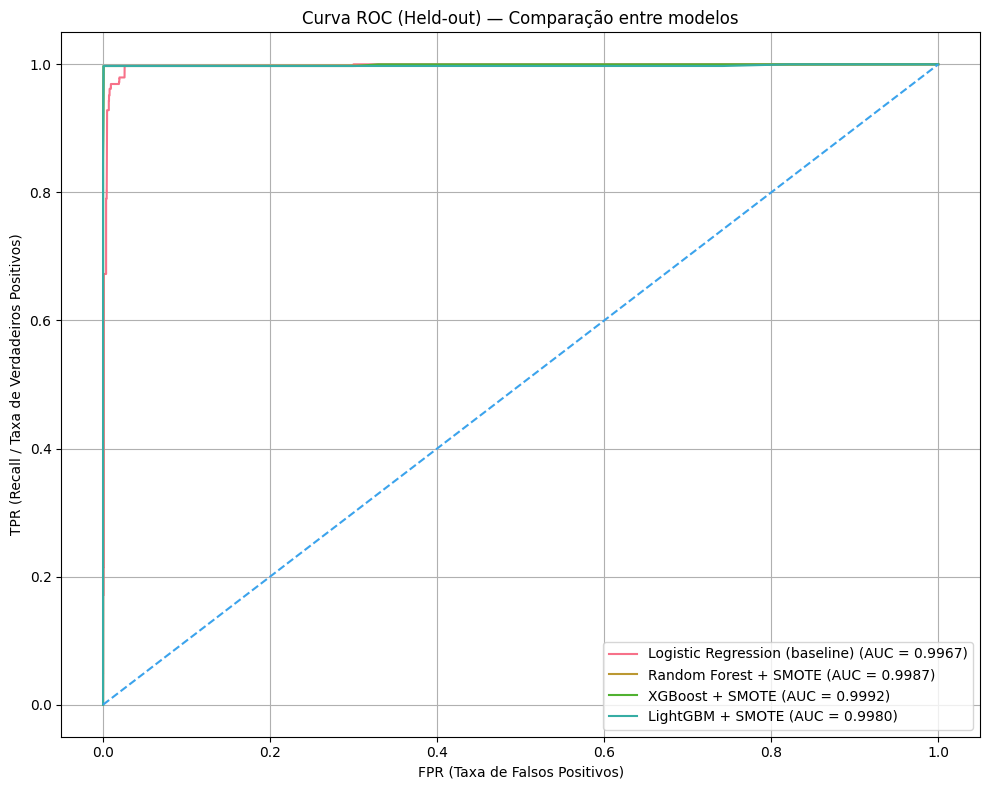

In [ ]:
#15 Curva ROC comparando os 4 modelos no conjunto de teste (held-out)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 1) Garante que temos as variáveis necessárias
needed = ["models", "create_pipeline", "X_train", "X_test", "y_train", "y_test"]
missing = [v for v in needed if v not in globals()]
if missing:
    raise NameError(f"Faltou executar células anteriores. Variáveis ausentes: {missing}")

# 2) Treina novamente cada modelo no treino completo e calcula as probabilidades no teste
plt.figure(figsize=(10, 8))

for model_name, config in models.items():
    pipe = create_pipeline(config["model"], use_smote=config["use_smote"])
    pipe.fit(X_train, y_train)

    # Probabilidade da classe positiva (PortScan = 1)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")

# 3) Linha de referência (classificador aleatório)
plt.plot([0, 1], [0, 1], linestyle="--")

plt.title("Curva ROC (Held-out) — Comparação entre modelos")
plt.xlabel("FPR (Taxa de Falsos Positivos)")
plt.ylabel("TPR (Recall / Taxa de Verdadeiros Positivos)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


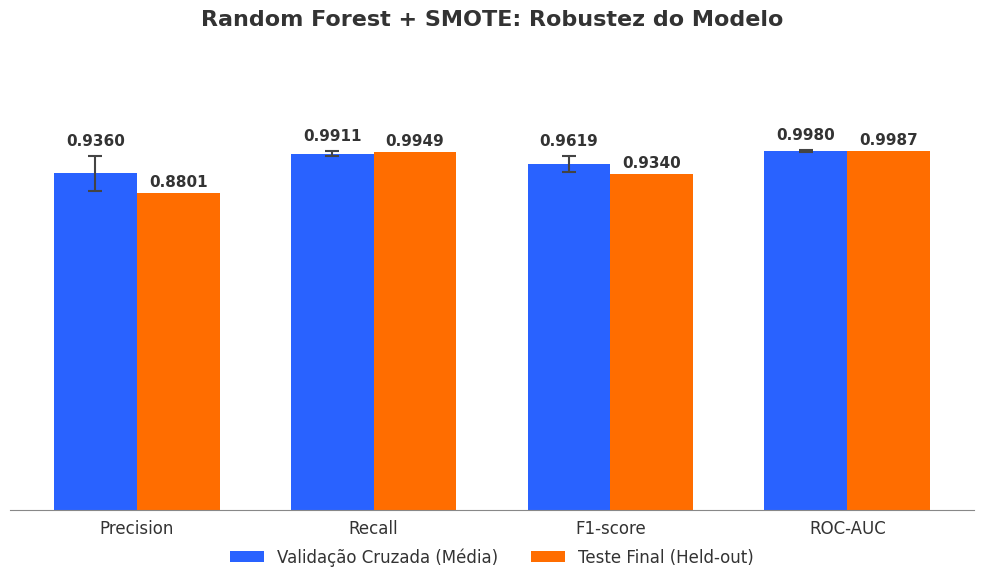

In [ ]:
#16 - Gera gráfico de robustez do melhor modelo, comparando as métricas da Validação Cruzada (CV) com as do Teste Final.

import matplotlib.pyplot as plt
import numpy as np

# --- CAPTURA DINÂMICA DE DADOS ---
# Certifique-se de ter rodado a célula "Análise Detalhada" antes desta!
# Estamos usando as variáveis 'best_cv_metrics' e 'best_test_metrics' geradas lá.

metrics = ["Precision", "Recall", "F1-score", "ROC-AUC"]

# Extrai as médias da Validação Cruzada (CV)
cv_mean = np.array([
    best_cv_metrics['cv_precision_mean'],
    best_cv_metrics['cv_recall_mean'],
    best_cv_metrics['cv_f1_mean'],
    best_cv_metrics['cv_roc_auc_mean']
])

# Extrai o Desvio Padrão do CV
cv_std = np.array([
    best_cv_metrics['cv_precision_std'],
    best_cv_metrics['cv_recall_std'],
    best_cv_metrics['cv_f1_std'],
    best_cv_metrics['cv_roc_auc_std']
])

# Extrai os resultados do Teste Final
test_val = np.array([
    best_test_metrics['test_precision'],
    best_test_metrics['test_recall'],
    best_test_metrics['test_f1'],
    best_test_metrics['test_roc_auc']
])

# --- CONFIGURAÇÃO DO GRÁFICO ---
x = np.arange(len(metrics))
width = 0.35

plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
ax.set_facecolor('white')

# Cores VIVAS
color_cv = "#2962FF"    # Azul Royal
color_test = "#FF6D00"  # Laranja Intenso
text_color = "#333333"  # Cinza Escuro

# Barras CV (Azul)
rects1 = ax.bar(
    x - width/2, cv_mean, width,
    yerr=cv_std, capsize=5,
    label="Validação Cruzada (Média)",
    color=color_cv,
    edgecolor='none',
    error_kw={"ecolor": "#444", "elinewidth": 1.5, "capthick": 1.5, "zorder": 5}
)

# Barras Teste (Laranja)
rects2 = ax.bar(
    x + width/2, test_val, width,
    label="Teste Final (Held-out)",
    color=color_test,
    edgecolor='none'
)

# Design Limpo
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#888')
ax.grid(axis='y', linestyle='--', alpha=0.3, color='gray', zorder=0)
ax.set_yticks([])

# Função de Rótulos Dinâmicos
def autolabel(rects, is_cv=False):
    for i, rect in enumerate(rects):
        height = rect.get_height()

        # Lógica para o texto não ficar em cima da linha de erro
        if is_cv:
            error_height = cv_std[i]
            y_pos = height + error_height + 0.02
        else:
            y_pos = height + 0.01

        ax.text(rect.get_x() + rect.get_width() / 2, y_pos,
                f'{height:.4f}', # .4f para mostrar a precisão exata que vem do código
                ha='center', va='bottom',
                fontsize=11, fontweight='bold', color=text_color)

autolabel(rects1, is_cv=True)
autolabel(rects2)

# Títulos Dinâmicos (Pega o nome do modelo automaticamente)
model_name = best_test_metrics['model']
ax.set_title(f"{model_name}: Robustez do Modelo",
             fontsize=16, fontweight='bold', pad=25, color=text_color)

ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12, fontweight='medium', color=text_color)
ax.set_ylim(0.0, 1.25)

# Legenda Forçada
leg = ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05),
                ncol=2, frameon=False, fontsize=12)
for text in leg.get_texts():
    text.set_color(text_color)

plt.tight_layout()
plt.show()

In [ ]:
#17 - Gera um relatório final comparando baseline vs melhor modelo, calcula melhorias (%) e imprime uma conclusão pronta.

print("\n" + "="*80)
print(f"📄 RELATÓRIO FINAL - DETECÇÃO DE {ATAQUE_TIPO}")
print("="*80 + "\n")

# Baseline
baseline_test = test_results_df[test_results_df['model'].str.contains('baseline')].iloc[0]

print("🔴 BASELINE (Logistic Regression sem balanceamento):")
print(f"  • Precision: {baseline_test['test_precision']:.4f}")
print(f"  • Recall:    {baseline_test['test_recall']:.4f}")
print(f"  • F1-Score:  {baseline_test['test_f1']:.4f}")
print(f"  • FPR:       {baseline_test['fpr']:.4%}")

print(f"\n🟢 MELHOR MODELO ({best_model_name}):")
print(f"  • Precision: {best_test_metrics['test_precision']:.4f}")
print(f"  • Recall:    {best_test_metrics['test_recall']:.4f}")
print(f"  • F1-Score:  {best_test_metrics['test_f1']:.4f}")
print(f"  • FPR:       {best_test_metrics['fpr']:.4%}")

print(f"\n📈 MELHORIAS ALCANÇADAS:")
prec_improvement = (best_test_metrics['test_precision'] / baseline_test['test_precision'] - 1) * 100
f1_improvement = (best_test_metrics['test_f1'] / baseline_test['test_f1'] - 1) * 100
fpr_reduction = (1 - best_test_metrics['fpr'] / baseline_test['fpr']) * 100

print(f"  • Precision:  {baseline_test['test_precision']:.4f} → {best_test_metrics['test_precision']:.4f} ({prec_improvement:+.1f}%)")
print(f"  • F1-Score:   {baseline_test['test_f1']:.4f} → {best_test_metrics['test_f1']:.4f} ({f1_improvement:+.1f}%)")
print(f"  • FPR:        {baseline_test['fpr']:.4%} → {best_test_metrics['fpr']:.4%} ({fpr_reduction:.1f}% de redução)")

print(f"\n✅ VALIDAÇÃO:")
print(f"  • Método: Stratified 5-Fold Cross-Validation")
print(f"  • Conjunto de teste: 20% dos dados (held-out)")
print(f"  • Estabilidade (CV std): {best_cv_metrics['cv_f1_std']:.4f}")
print(f"  • Generalização (CV→Test diff): {f1_diff:+.4f}")

print(f"\n💬 CONCLUSÃO:")
print(f"  O modelo {best_model_name} alcançou F1-Score de {best_test_metrics['test_f1']:.4f}")
print(f"  em dados não vistos, representando uma melhoria de {f1_improvement:.1f}% sobre")
print(f"  o baseline. A validação cruzada demonstrou estabilidade (std={best_cv_metrics['cv_f1_std']:.4f})")
print(f"  e a taxa de falsos alarmes foi reduzida em {fpr_reduction:.1f}%, tornando o")
print(f"  sistema viável para implantação em ambientes de produção.")

print("\n" + "="*80)


📄 RELATÓRIO FINAL - DETECÇÃO DE PortScan

🔴 BASELINE (Logistic Regression sem balanceamento):
  • Precision: 0.1992
  • Recall:    0.9693
  • F1-Score:  0.3304
  • FPR:       1.3220%

🟢 MELHOR MODELO (Random Forest + SMOTE):
  • Precision: 0.8801
  • Recall:    0.9949
  • F1-Score:  0.9340
  • FPR:       0.0460%

📈 MELHORIAS ALCANÇADAS:
  • Precision:  0.1992 → 0.8801 (+341.9%)
  • F1-Score:   0.3304 → 0.9340 (+182.7%)
  • FPR:        1.3220% → 0.0460% (96.5% de redução)

✅ VALIDAÇÃO:
  • Método: Stratified 5-Fold Cross-Validation
  • Conjunto de teste: 20% dos dados (held-out)
  • Estabilidade (CV std): 0.0232
  • Generalização (CV→Test diff): -0.0280

💬 CONCLUSÃO:
  O modelo Random Forest + SMOTE alcançou F1-Score de 0.9340
  em dados não vistos, representando uma melhoria de 182.7% sobre
  o baseline. A validação cruzada demonstrou estabilidade (std=0.0232)
  e a taxa de falsos alarmes foi reduzida em 96.5%, tornando o
  sistema viável para implantação em ambientes de produção.



In [ ]:
#18 - Salva CSVs (CV, teste, comparação) e imprime uma tabela LaTeX

results_dir = Path("/content/results")
results_dir.mkdir(exist_ok=True)

# Salvar resultados de CV
cv_file = results_dir / f"cv_results_{ATAQUE_TIPO.lower()}.csv"
cv_results_df.to_csv(cv_file, index=False)

# Salvar resultados de teste
test_file = results_dir / f"test_results_{ATAQUE_TIPO.lower()}.csv"
test_results_df.to_csv(test_file, index=False)

# Salvar comparação
comparison_file = results_dir / f"comparison_cv_test_{ATAQUE_TIPO.lower()}.csv"
comparison_df.to_csv(comparison_file, index=False)

print(f"✅ Resultados salvos:")
print(f"  • {cv_file}")
print(f"  • {test_file}")
print(f"  • {comparison_file}")

# Criar tabela LaTeX
print(f"\n📊 TABELA LATEX:\n")
print("\\begin{table}[h]")
print("\\centering")
print(f"\\caption{{Comparação de Modelos para Detecção de {ATAQUE_TIPO}}}")
print("\\label{tab:" + ATAQUE_TIPO.lower() + "_results}")
print("\\begin{tabular}{lcccccc}")
print("\\hline")
print("\\textbf{Modelo} & \\textbf{Precision} & \\textbf{Recall} & \\textbf{F1-Score} & \\textbf{FPR} & \\textbf{CV Std} \\\\")
print("\\hline")

for idx, row in comparison_df.iterrows():
    model_short = row['model'].replace('+ SMOTE', '+SMOTE').replace(' (baseline)', '').replace('Logistic Regression', 'LogReg')
    cv_metrics = cv_results_df[cv_results_df['model'] == row['model']].iloc[0]
    print(f"{model_short} & {row['test_precision']:.4f} & {row['test_recall']:.4f} & "
          f"{row['test_f1']:.4f} & {test_results_df[test_results_df['model']==row['model']].iloc[0]['fpr']:.4%} & "
          f"{cv_metrics['cv_f1_std']:.4f} \\\\")

print("\\hline")
print("\\end{tabular}")
print("\\end{table}")

print(f"\n🎉 Análise completa! Para testar outro ataque, volte na CÉLULA 3 e mude ATAQUE_TIPO")

✅ Resultados salvos:
  • /content/results/cv_results_portscan.csv
  • /content/results/test_results_portscan.csv
  • /content/results/comparison_cv_test_portscan.csv

📊 TABELA LATEX:

\begin{table}[h]
\centering
\caption{Comparação de Modelos para Detecção de PortScan}
\label{tab:portscan_results}
\begin{tabular}{lcccccc}
\hline
\textbf{Modelo} & \textbf{Precision} & \textbf{Recall} & \textbf{F1-Score} & \textbf{FPR} & \textbf{CV Std} \\
\hline
Random Forest +SMOTE & 0.8801 & 0.9949 & 0.9340 & 0.0460% & 0.0232 \\
LightGBM +SMOTE & 0.8647 & 0.9974 & 0.9264 & 0.0529% & 0.0288 \\
XGBoost +SMOTE & 0.8442 & 0.9974 & 0.9144 & 0.0625% & 0.0316 \\
LogReg & 0.1992 & 0.9693 & 0.3304 & 1.3220% & 0.0473 \\
\hline
\end{tabular}
\end{table}

🎉 Análise completa! Para testar outro ataque, volte na CÉLULA 3 e mude ATAQUE_TIPO
